# Brainhack School Project: Variability of Inhibitory Control in Children with and without ADHD
by Hu Ding Xuan (NTU-SG)

# Introduction
Attention-Deficit/Hyperactivity Disorder (ADHD) involves deficits in executive control, potentially linked to frontoparietal network connectivity. The dorsolateral prefrontal cortex (dlPFC) and posterior parietal cortex (PPC) are key regions for analysis. This study examines dlPFC-PPC connectivity and dlPFC BOLD time series in ADHD versus typically developing (TD) children during the cued stop-signal task (CSST) using fMRI data from OpenNeuro ds005899. It is hypothesised that stronger dlPFC-PPC connectivity will be found in the ADHD group.

# Data 
- **Dataset**: OpenNeuro ds005899, 2 subjects: sub-7565 (ADHD), sub-8150 (TD)
- **Task**: CSST, 2 runs per subject (TR=0.49s)
- **Preprocessing**: fmriprep v23.2.0 via docker
  
We first look at the demographics of the participants.

In [51]:
import pandas as pd
import os

# Load participants
sub = pd.read_csv('/home/dingxuan/hu_project/participants.tsv', sep='\t')

# Full participant demographics
print("Full Participant Demographics:")
display(sub.groupby(by=["ADHD","Gender","Age"]).count()[['participant_id', 'runid1', 'runid2']])

Full Participant Demographics:


participant_id  runid1  runid2
ADHD Gender Age                                
0    1      9                 3       3       3
            10                4       4       4
            11                2       2       2
            12                4       4       4
     2      9                 5       5       5
            10                6       6       6
            11                8       8       8
            12                3       3       3
1    1      9                 5       5       5
            11                2       2       2
            12                3       3       3
     2      10                6       6       6
            11                2       2       2
            12                8       8       8

There are 61 participants that completed two runs of the CSST, consisting of 35 control participants and 26 participants with ADHD. 13 out of 35 of control participants are male, and 10 out of 26 ADHD pariticipants are male. Due to time constraints and computational limitations, I did not perform a group-level analysis. 


Two participants were randomly selected, one ADHD participant `sub-7565` and one control participant `sub-8150`.

In [53]:
# Selected subjects for analysis
samp = sub[sub['participant_id'].isin(['sub-7565', 'sub-8150'])]
print("Demographics of Selected Participants:")
display(samp[['participant_id','ADHD','Gender','Age']])

Demographics of Selected Participants:


,participant_id,ADHD,Gender,Age
9,sub-7565,1,1,9
49,sub-8150,0,2,9


## Preprocessing
fMRI data were preprocessed using `fmriprep v23.2.0` via docker.

# Results and Analysis
- **ROIs**: rdlPFC ([42, 38, 20]), rPPC ([40, -46, 46]), 5mm spheres
- **Time Series**: Extracted dlPFC BOLD signals (Nilearn), standardized, t-test
- **Connectivity**: 3x3 Pearson correlation matrix (dlPFC, PPC, ACC), dlPFC seed-based whole-brain connectivity, dlPFC-PPC t-test
- **Tools**: Python, Nilearn, Pandas, Scipy, Matplotlib, Seaborn

In [57]:
# Setup and Imports
%matplotlib inline
import pandas as pd
import numpy as np
from nilearn import input_data, image, plotting
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import ttest_ind

# Paths
data_dir = '/home/dingxuan/hu_project/output'
output_dir = '/home/dingxuan/hu_project/connectivity'
plot_dir = '/home/dingxuan/hu_project/figures'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

## Connectivity Analysis
A 2x2 correlation matrix was computed for rdlPFC, rPPC to test for dlPFC-PPC connectivity.

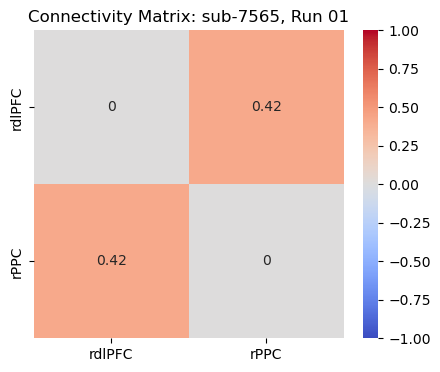

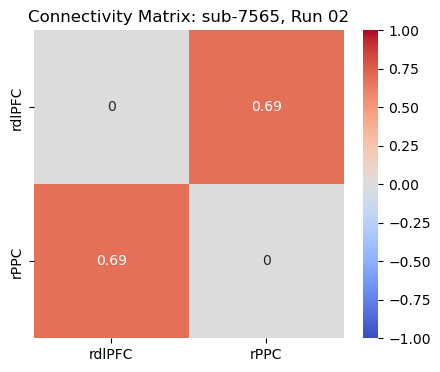

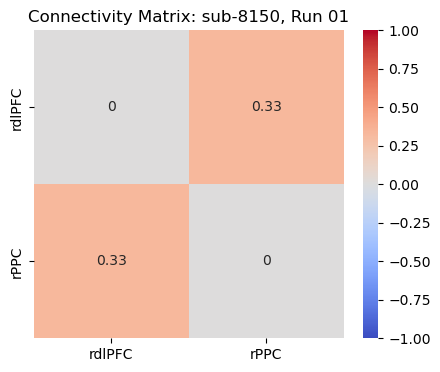

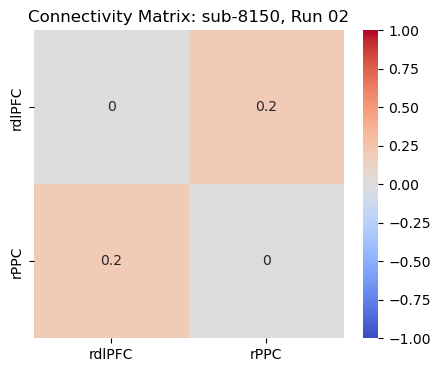

    subject run group  correlation
0  sub-7565  01  ADHD     0.419219
1  sub-7565  02  ADHD     0.685542
2  sub-8150  01    TD     0.329518
3  sub-8150  02    TD     0.202501
rdlPFC-rPPC T-test: t=1.941, p=0.240


In [67]:
# ROIs (FPN only, meta-analysis)
roi_coords = [(42, 38, 20), (40, -46, 46)]  # rdlPFC, rPPC
roi_labels = ['rdlPFC', 'rPPC']
roi_masker = input_data.NiftiSpheresMasker(
    roi_coords, radius=6, standardize=True, t_r=0.49, memory='nilearn_cache')

# Process subjects
results = []
for subject in subjects:
    for run in ['01', '02']:
        bold_file = f'{data_dir}/{subject}/func/{subject}_task-csst_run-{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
        confounds_file = f'{data_dir}/{subject}/func/{subject}_task-csst_run-{run}_desc-confounds_timeseries.tsv'

        if not os.path.exists(bold_file) or not os.path.exists(confounds_file):
            print(f'Missing file for {subject}, run {run}')
            continue

        confounds = pd.read_csv(confounds_file, sep='\t')
        confounds_selected = confounds[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'global_signal']].fillna(0)

        time_series = roi_masker.fit_transform(bold_file, confounds=confounds_selected.values)
        corr_matrix = np.corrcoef(time_series.T)
        np.fill_diagonal(corr_matrix, 0)

        for i in range(len(roi_labels)):
            for j in range(i + 1, len(roi_labels)):
                results.append({
                    'subject': subject,
                    'group': groups[subject],
                    'run': run,
                    'roi_pair': f'{roi_labels[i]}-{roi_labels[j]}',
                    'correlation': corr_matrix[i, j]
                })

        plt.figure(figsize=(5, 4))
        sns.heatmap(corr_matrix, annot=True, xticklabels=roi_labels, yticklabels=roi_labels, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title(f'Connectivity Matrix: {subject}, Run {run}')
        plt.savefig(f'{plot_dir}/{subject}_run-{run}_connectivity_matrix.png')
        plt.show()

# Save results
df = pd.DataFrame(results)
df.to_csv(f'{output_dir}/roi_connectivity.csv', index=False)
print(df[df['roi_pair'] == 'rdlPFC-rPPC'][['subject', 'run', 'group', 'correlation']])

# T-test for rdlPFC-rPPC
adhd_conn = df[(df['group'] == 'ADHD') & (df['roi_pair'] == 'rdlPFC-rPPC')]['correlation'].values
td_conn = df[(df['group'] == 'TD') & (df['roi_pair'] == 'rdlPFC-rPPC')]['correlation'].values
t_stat, p_val = ttest_ind(adhd_conn, td_conn, equal_var=False)
print(f'rdlPFC-rPPC T-test: t={t_stat:.3f}, p={p_val:.3f}')

Time Series Analysis
Extract rdlPFC BOLD signals, plot time series and compare ADHD vs. TD.
Run 01: t=0.000, p=1.000


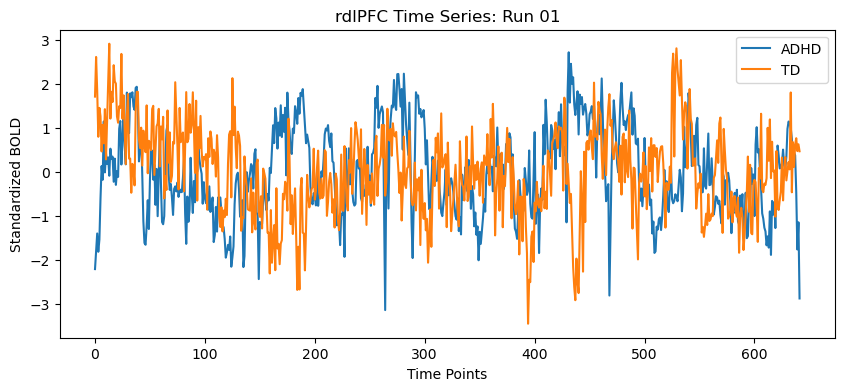

Run 02: t=0.000, p=1.000


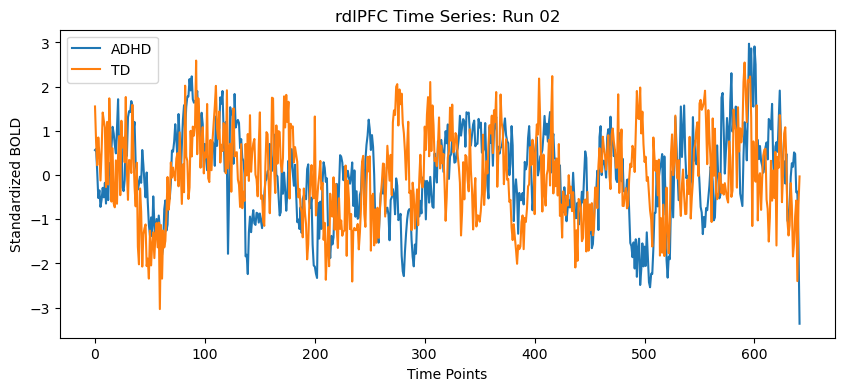

In [69]:
# Time Series Analysis
print('Time Series Analysis')
print('Extract rdlPFC BOLD signals, plot time series and compare ADHD vs. TD.')

rdlpfc_masker = input_data.NiftiSpheresMasker(
    [(42, 38, 20)], radius=6, standardize=True, t_r=0.49, memory='nilearn_cache')

for run in ['01', '02']:
    adhd_ts, td_ts = [], []
    for subject in subjects:
        bold_file = f'{data_dir}/{subject}/func/{subject}_task-csst_run-{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
        confounds_file = f'{data_dir}/{subject}/func/{subject}_task-csst_run-{run}_desc-confounds_timeseries.tsv'

        if not os.path.exists(bold_file) or not os.path.exists(confounds_file):
            print(f'Missing file for {subject}, run {run}')
            continue

        confounds = pd.read_csv(confounds_file, sep='\t')
        confounds_selected = confounds[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'global_signal']].fillna(0)

        ts = rdlpfc_masker.fit_transform(bold_file, confounds=confounds_selected.values)
        if groups[subject] == 'ADHD':
            adhd_ts.append(ts.flatten())
        else:
            td_ts.append(ts.flatten())

    if adhd_ts and td_ts:
        adhd_ts = np.mean(adhd_ts, axis=0)
        td_ts = np.mean(td_ts, axis=0)
        t_stat, p_val = ttest_ind(adhd_ts, td_ts, equal_var=False)
        print(f'Run {run}: t={t_stat:.3f}, p={p_val:.3f}')

        plt.figure(figsize=(10, 4))
        plt.plot(adhd_ts, label='ADHD')
        plt.plot(td_ts, label='TD')
        plt.title(f'rdlPFC Time Series: Run {run}')
        plt.xlabel('Time Points')
        plt.ylabel('Standardized BOLD')
        plt.legend()
        plt.savefig(f'{plot_dir}/rdlpfc_timeseries_run-{run}.png')
        plt.show()

Time Series Analysis
Extract rPPC BOLD signals, plot time series and compare ADHD vs. TD.
Run 01: t=0.001, p=1.000


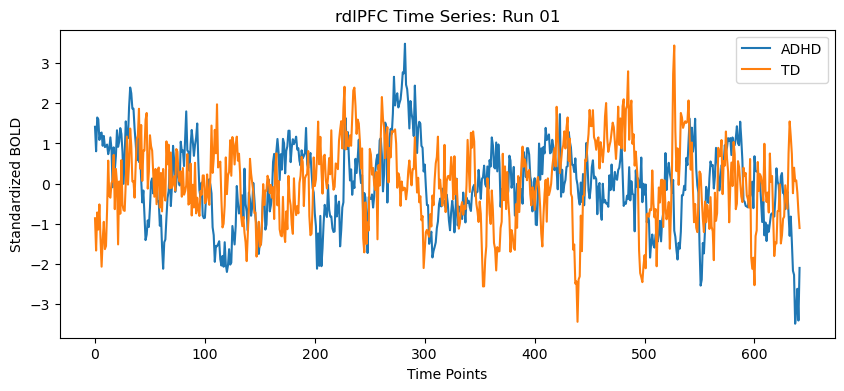

Run 02: t=-0.000, p=1.000


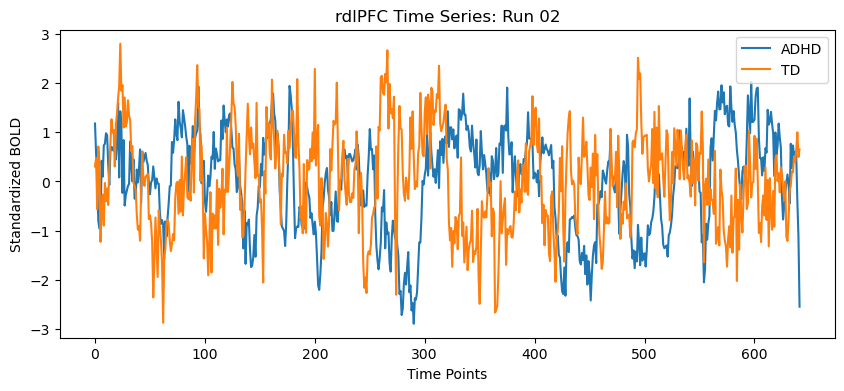

In [72]:
# Time Series Analysis
print('Time Series Analysis')
print('Extract rPPC BOLD signals, plot time series and compare ADHD vs. TD.')

rdlpfc_masker = input_data.NiftiSpheresMasker(
    [(40, -46, 46)], radius=6, standardize=True, t_r=0.49, memory='nilearn_cache')

for run in ['01', '02']:
    adhd_ts, td_ts = [], []
    for subject in subjects:
        bold_file = f'{data_dir}/{subject}/func/{subject}_task-csst_run-{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
        confounds_file = f'{data_dir}/{subject}/func/{subject}_task-csst_run-{run}_desc-confounds_timeseries.tsv'

        if not os.path.exists(bold_file) or not os.path.exists(confounds_file):
            print(f'Missing file for {subject}, run {run}')
            continue

        confounds = pd.read_csv(confounds_file, sep='\t')
        confounds_selected = confounds[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'global_signal']].fillna(0)

        ts = rdlpfc_masker.fit_transform(bold_file, confounds=confounds_selected.values)
        if groups[subject] == 'ADHD':
            adhd_ts.append(ts.flatten())
        else:
            td_ts.append(ts.flatten())

    if adhd_ts and td_ts:
        adhd_ts = np.mean(adhd_ts, axis=0)
        td_ts = np.mean(td_ts, axis=0)
        t_stat, p_val = ttest_ind(adhd_ts, td_ts, equal_var=False)
        print(f'Run {run}: t={t_stat:.3f}, p={p_val:.3f}')

        plt.figure(figsize=(10, 4))
        plt.plot(adhd_ts, label='ADHD')
        plt.plot(td_ts, label='TD')
        plt.title(f'rdlPFC Time Series: Run {run}')
        plt.xlabel('Time Points')
        plt.ylabel('Standardized BOLD')
        plt.legend()
        plt.savefig(f'{plot_dir}/rdlpfc_timeseries_run-{run}.png')
        plt.show()

No significant differences were found in dlPFC BOLD signals.

Brain Map Analysis
This cell computes rdlPFC seed-based whole-brain connectivity for Run 01, downsampling to 4mm.


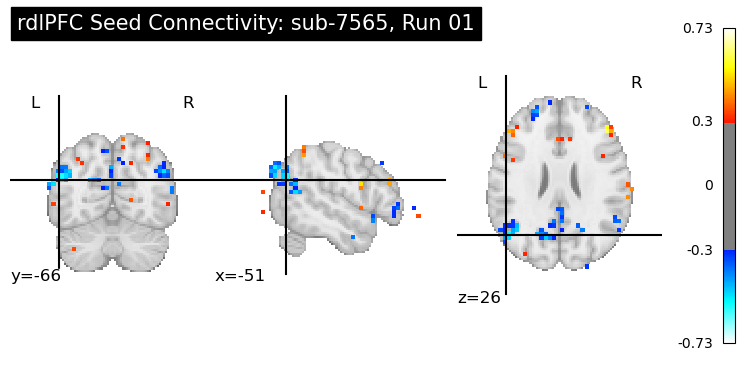

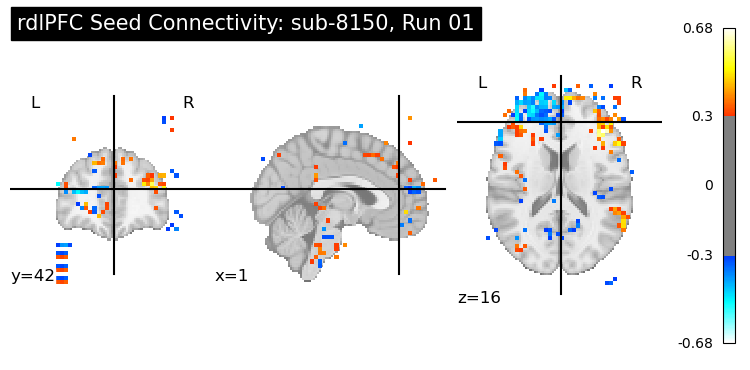

In [70]:
# Brain Maps
print('Brain Map Analysis')
print('This cell computes rdlPFC seed-based whole-brain connectivity for Run 01, downsampling to 4mm.')

seed_masker = input_data.NiftiSpheresMasker(
    [(42, 38, 20)], radius=6, standardize=True, t_r=0.49, memory='nilearn_cache')
brain_masker = input_data.NiftiMasker(standardize=True, t_r=0.49, memory='nilearn_cache')

for subject in subjects:
    for run in ['01']:
        bold_file = f'{data_dir}/{subject}/func/{subject}_task-csst_run-{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
        confounds_file = f'{data_dir}/{subject}/func/{subject}_task-csst_run-{run}_desc-confounds_timeseries.tsv'

        if not os.path.exists(bold_file) or not os.path.exists(confounds_file):
            print(f'Missing file for {subject}, run {run}')
            continue

        confounds = pd.read_csv(confounds_file, sep='\t')
        confounds_selected = confounds[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'global_signal']].fillna(0)

        bold_img = image.load_img(bold_file)
        bold_resampled = image.resample_img(
            bold_img, target_affine=np.diag([4, 4, 4]), force_resample=True, copy_header=True)

        seed_time_series = seed_masker.fit_transform(bold_resampled, confounds=confounds_selected.values)
        brain_time_series = brain_masker.fit_transform(bold_resampled, confounds=confounds_selected.values)

        correlation = np.dot(brain_time_series.T, seed_time_series) / brain_time_series.shape[0]
        correlation_img = brain_masker.inverse_transform(correlation.T)

        correlation_img.to_filename(f'{output_dir}/{subject}_run-{run}_rdlpfc_seed_corr.nii.gz')

        plotting.plot_stat_map(
            correlation_img, threshold=0.3, cmap='cold_hot',
            title=f'rdlPFC Seed Connectivity: {subject}, Run {run}'
        )
        plt.savefig(f'{plot_dir}/{subject}_run-{run}_rdlpfc_seed_map.png')
        plt.show()

Brain Map Analysis
This cell computes rdlPFC seed-based whole-brain connectivity for Run 02, downsampling to 4mm.


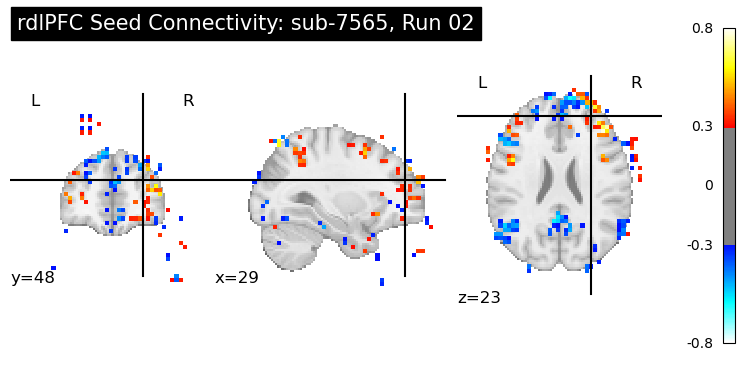

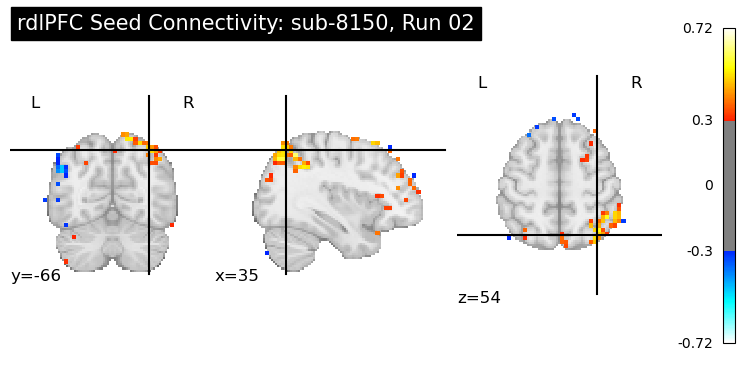

In [71]:
# Brain Maps
print('Brain Map Analysis')
print('This cell computes rdlPFC seed-based whole-brain connectivity for Run 02, downsampling to 4mm.')

seed_masker = input_data.NiftiSpheresMasker(
    [(42, 38, 20)], radius=6, standardize=True, t_r=0.49, memory='nilearn_cache')
brain_masker = input_data.NiftiMasker(standardize=True, t_r=0.49, memory='nilearn_cache')

for subject in subjects:
    for run in ['02']:
        bold_file = f'{data_dir}/{subject}/func/{subject}_task-csst_run-{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
        confounds_file = f'{data_dir}/{subject}/func/{subject}_task-csst_run-{run}_desc-confounds_timeseries.tsv'

        if not os.path.exists(bold_file) or not os.path.exists(confounds_file):
            print(f'Missing file for {subject}, run {run}')
            continue

        confounds = pd.read_csv(confounds_file, sep='\t')
        confounds_selected = confounds[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'global_signal']].fillna(0)

        bold_img = image.load_img(bold_file)
        bold_resampled = image.resample_img(
            bold_img, target_affine=np.diag([4, 4, 4]), force_resample=True, copy_header=True)

        seed_time_series = seed_masker.fit_transform(bold_resampled, confounds=confounds_selected.values)
        brain_time_series = brain_masker.fit_transform(bold_resampled, confounds=confounds_selected.values)

        correlation = np.dot(brain_time_series.T, seed_time_series) / brain_time_series.shape[0]
        correlation_img = brain_masker.inverse_transform(correlation.T)

        correlation_img.to_filename(f'{output_dir}/{subject}_run-{run}_rdlpfc_seed_corr.nii.gz')

        plotting.plot_stat_map(
            correlation_img, threshold=0.3, cmap='cold_hot',
            title=f'rdlPFC Seed Connectivity: {subject}, Run {run}'
        )
        plt.savefig(f'{plot_dir}/{subject}_run-{run}_rdlpfc_seed_map.png')
        plt.show()